---
fig-cap-location: margin
code-fold: false
---


### Abstract

In this blog post, I take the Palmer Penguins dataset and try to determine the best features to be used to determine the species of a penguin based on its measurements. Firstly, I create two figures and a table to analysize the relationships between features. Then I use sci-kit learns feature selection with chi-squared tests to pick 2 numerical features and 1 categorical feature. Then using those features, I train and test a logistic regression model. The model was fairly accurate but to understand the results better, I plot the decision regions and use a confusion matrix. 

In [2]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [3]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


### Data Preparation

This is code from Professor Phil's website. It removes the columns that we don't use and NA values, converts the categorical feature columns into "one-hot encoded" 0-1 columns and saves the dataframe X_train. Also, "Species" is coded with the LabelEncoder and is saved as y_train.

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

We can check what the columns look like now.

In [5]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


### Data Visualization

I created two graphs each 2 quantative columns and 1 qualitative columns. Plot 1 shows the relationship with the body mass and flipper length in penguins on different islands. Plot 2 shows the difference in Culmen Length and depth between male and female penguins.


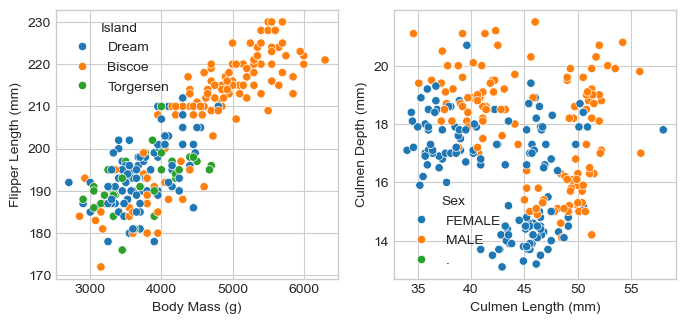

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))

# Get the unencoded columns for easier graphing.
qual = train[["Island", "Sex"]].dropna()

p1 = sns.scatterplot(X_train, x = "Body Mass (g)", y = "Flipper Length (mm)", hue= qual["Island"], ax = ax[0])
p2 = sns.scatterplot(X_train, x = "Culmen Length (mm)", y = "Culmen Depth (mm)", hue=qual["Sex"], ax = ax[1])

Left side: Plot 1. The Penguins on Biscoe tend to be the biggest but also have the greatest variety in body mass and flipper length. This could mean the the Biscoe Island has a biggest penguin population and therefore have a greater variety of penguin species. Investigating into the Island_Biscoe feature might be worth modeling.   

Right side: Plot 2. Based on the graph, male penguins have slightly bigger culmens but not by much. Given how close the size between male and female culmen sizes are, these may be features worth modeling. 

Now I create a summary table of the penguins measurements based on clutch completetion. 

In [7]:
table = X_train[["Clutch Completion_Yes", "Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]]
table.groupby("Clutch Completion_Yes").aggregate(['min', 'median', 'max'])

Culmen Length (mm)              Culmen Depth (mm)  \
                                     min median   max               min   
Clutch Completion_Yes                                                     
False                               35.9  43.35  58.0              13.7   
True                                34.0  45.10  55.9              13.1   

                                   Flipper Length (mm)                \
                      median   max                 min median    max   
Clutch Completion_Yes                                                  
False                  17.85  19.9               172.0  195.0  225.0   
True                   17.20  21.5               176.0  198.0  230.0   

                      Body Mass (g)                  
                                min  median     max  
Clutch Completion_Yes                                
False                        2700.0  3737.5  5700.0  
True                         2850.0  4100.0  6300.0

Table 1: This table shows the biggest difference between penguins that had a full clutch and those that did not was the weight. Most of the penguins the produced two eggs weighed about 300 grams more. There is most likely not a causation but there a may be a correlation. Since clutch completion does not seem impact this data very much, it may not be a feature worth looking at.

### Feature selection 

Here I use sci-kits SelectKBest to pick the 3 feautures I'm going to use for my model. I had to seperate feature selection because all 3 selected features would be numerical. 

In [8]:
from sklearn.feature_selection import SelectKBest, chi2

# Selecting 2 numerical feature
quant = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']
sel1 = SelectKBest(chi2, k=2)
sel1.fit_transform(X_train[quant], y_train)
f1 = sel1.get_feature_names_out()

# Selecting 1 categorical feature
qual = ["Clutch Completion_Yes", "Clutch Completion_No", "Island_Biscoe", "Island_Dream", "Island_Torgersen", "Sex_FEMALE", "Sex_MALE"]
sel2 = SelectKBest(chi2, k=1)
sel2.fit_transform(X_train[qual], y_train)
f2 = sel2.get_feature_names_out()


This function is so that I can get all the variations of the categorical feature.

In [9]:
def get_feat(f1, cat):
    cols = list(f1)
    clutch = ["Clutch Completion_Yes", "Clutch Completion_No"]
    island = ["Island_Biscoe", "Island_Dream", "Island_Torgersen"]
    sex = ["Sex_FEMALE", "Sex_MALE"]
    
    if cat in clutch: return cols + clutch
    if cat in island: return cols + island
    if cat in sex: return cols + sex

In [10]:
cols = get_feat(f1, f2[0])
cols

['Flipper Length (mm)',
 'Body Mass (g)',
 'Island_Biscoe',
 'Island_Dream',
 'Island_Torgersen']

### Training

The model is trained on the data with features determined from above. I had to use StandardScalar to avoid a convergence error.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train[cols], y_train)
pipe.score(X_train[cols], y_train)

# LR = LogisticRegression(max_iter=1000)
# LR.fit(X_train[cols], y_train)
# LR.score(X_train[cols], y_train)


0.8984375

### Testing

In [13]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
pipe.score(X_test[cols], y_test)

0.8970588235294118

### Plotting Decision Regions 

Most of this code is adapted from Prof. Phil's website.

In [14]:
from matplotlib import pyplot as plt
import numpy as np

In [15]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (8, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

Regions for training set:

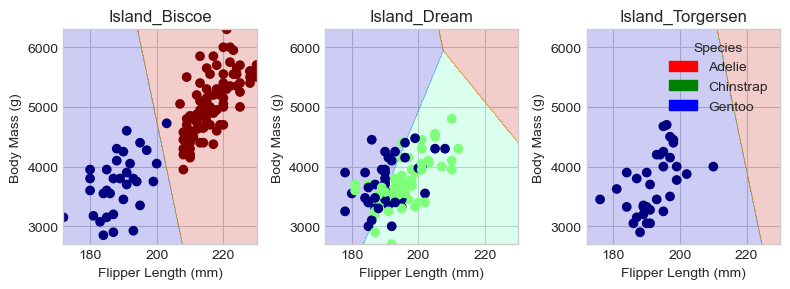

In [16]:
plot_regions(pipe, X_train[cols], y_train)

Regions for testing set:

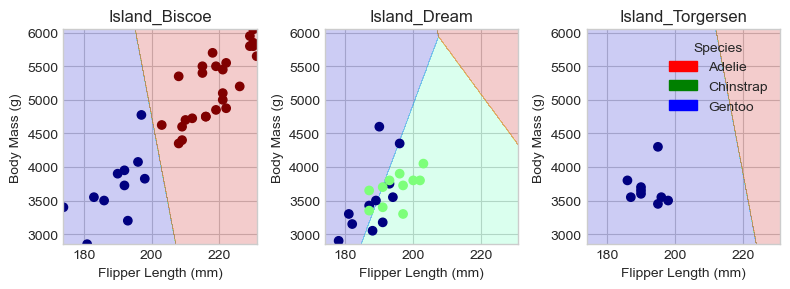

In [17]:
plot_regions(pipe, X_test[cols], y_test)

Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix

y_test_pred = pipe.predict(X_test[cols])
confusion_matrix(y_test, y_test_pred)


array([[26,  5,  0],
       [ 2,  9,  0],
       [ 0,  0, 26]])

### Discussion

The model had very similar training and testing accuracy of 0.89. This means the model is fairly solid at predicting penguins based on the flipper lenth, body mass and island. Based on the decision regions, the model struggled to correctly determine the difference between Chinstrap and Gentoo on the Island Dream. It seems that those 2 species are of similar sizes and therefore are hard to differentiate. 

During this blog post, the two biggest things were I learned about different tools for feature selection and the need to normalize data before putting it in a model. 